# Original ResNets 

We consider networks implementation available in [`torchvision`](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).

["Deep Residual Learning for Image Recognition" Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/pdf/1512.03385.pdf)

## Overview

A ResNet is composed of 5 parts that produce image features that can be further classified with a fully-connected layer:

```
--[Prep]--->[L1]->[L2]->[L3]->[L4]--->[Pool]->[FC]---
```

The first part is a preparation block composed of 
```
---[Conv]-[BN]-[ReLU]-[MaxPool]---

Conv = Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
BN = BatchNorm2d(64)
MaxPool = MaxPool2d(kernel_size=3, stride=2, padding=1)
```
and helps to adapt the input data.

### Residual blocks

Parts noted as `L1`, ..., `L4` are composed of a residual blocks. A residual block can be of type:

- basic block for shallow networks
- bottleneck block for deeper networks

and contains a "shortcut": 

- identity 
- projection

```
Li : ---[Projection/Identity]--[Identity]--[Identity]--...--[Identity]---
```

#### Basic block

1) Identity shortcut

```
        M->M                    M->M 
---.--[Conv3x3]-[BN]-[ReLU]--[Conv3x3]-[BN]--[+]--[ReLU]---
   |                                          | 
   |------------------------------------------|
```


2) Projection shortcut

```
        M->K                   K->K
---.--[Conv3x3]-[BN]-[ReLU]--[Conv3x3]-[BN]--[+]--[ReLU]---
   |   stride=2                               |
   |                                          | 
   |    M->K                                  | 
   |--[Conv1x1]-[BN]--------------------------|
       stride=2
```

#### Bottleneck block

1) Identity shortcut

```
       M -> M/4               M/4->M/4               M/4 -> M
---.--[Conv3x3]-[BN]-[ReLU]--[Conv3x3]-[BN]-[ReLU]--[Conv3x3]-[BN]--[+]--[ReLU]---
   |                                                                 | 
   |-----------------------------------------------------------------|
```


2) Projection shortcut

```
       M->K                    K->K                  K->K*4
---.--[Conv1x1]-[BN]-[ReLU]--[Conv3x3]-[BN]-[ReLU]--[Conv1x1]-[BN]--[+]--[ReLU]---
   |   stride=1 or 2                                                 |
   |                                                                 | 
   |   M->K*4                                                        | 
   |--[Conv1x1]-[BN]-------------------------------------------------|
       stride=1 or 2  
```



In [1]:
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

In [2]:
BasicBlock.__init__??

Signature: BasicBlock.__init__(self, inplanes, planes, stride=1, downsample=None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
File:      /usr/local/lib/python3.5/dist-packages/torchvision/models/resnet.py
Type:      function


In [3]:
BasicBlock.forward??

Signature: BasicBlock.forward(self, x)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
File:      /usr/local/lib/python3.5/dist-packages/torchvision/models/resnet.py
Type:      function


In [4]:
Bottleneck.__init__??

Signature: Bottleneck.__init__(self, inplanes, planes, stride=1, downsample=None)
Docstring: Initialize self.  See help(type(self)) for accurate signature.
Source:   
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
File:      /usr/local/lib/python3.5/dist-packages/torchvision/models/resnet.py
Type:      function


In [5]:
Bottleneck.forward??

Signature: Bottleneck.forward(self, x)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
File:      /usr/local/lib/python3.5/dist-packages/torchvision/models/resnet.py
Type:      function


## Example networks

In [6]:
import sys
sys.path.insert(0, "../common")

In [7]:
import torch

from dot import make_dot

### Resnet18

Network contains (2, 2, 2, 2) basic blocks

```
model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
```

In [8]:
from torchvision.models.resnet import resnet18

In [9]:
model = resnet18(pretrained=False)

x = torch.rand(2, 3, 224, 224)

Preparation block

In [10]:
y = model.conv1(x)
y = model.bn1(y)
y = model.relu(y)
y = model.maxpool(y)
y.shape

torch.Size([2, 64, 56, 56])

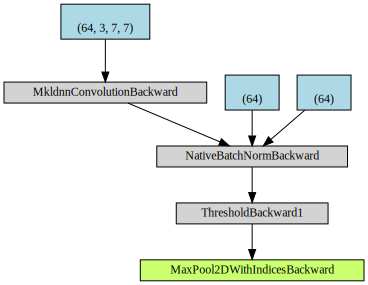

In [11]:
make_dot(y)

Layer 1

In [12]:
model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [13]:
y = torch.rand(2, 64, 112, 112, requires_grad=True)
y1 = model.layer1(y)
y1.shape

torch.Size([2, 64, 112, 112])

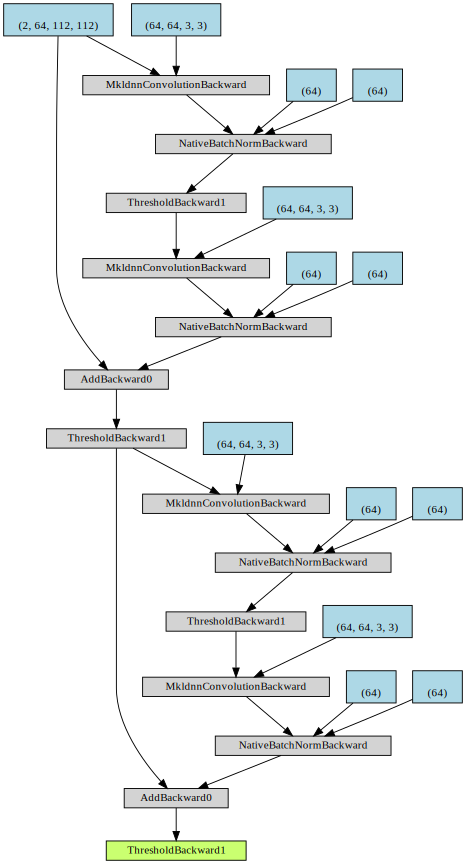

In [14]:
make_dot(y1)

Layer 2

In [15]:
model.layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

torch.Size([2, 64, 56, 56]) torch.Size([2, 128, 28, 28])


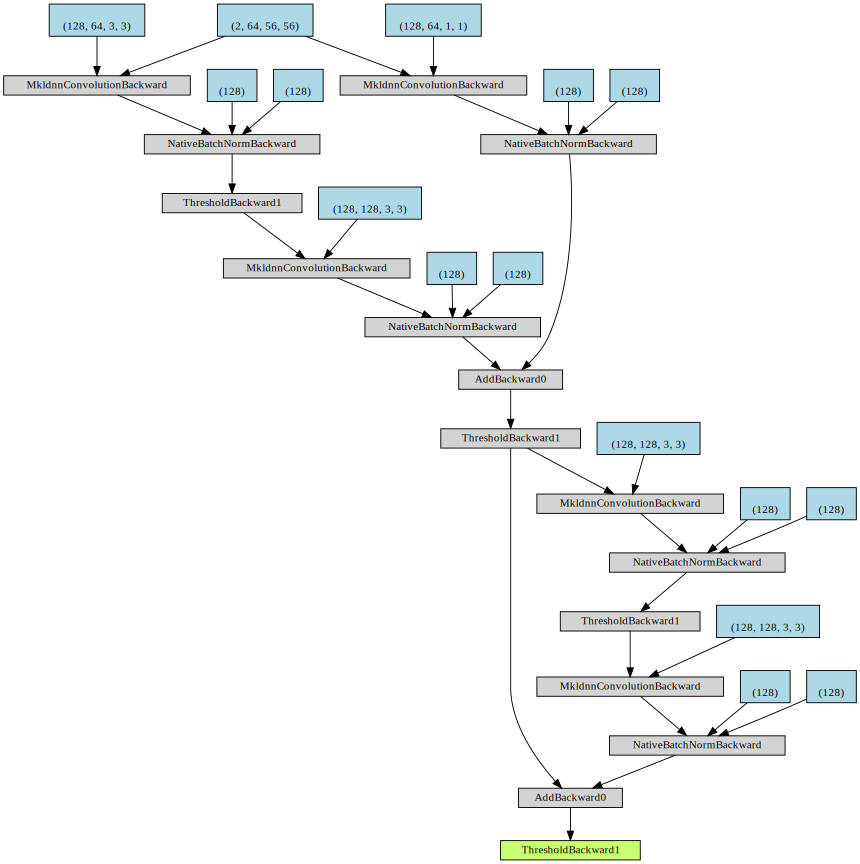

In [16]:
y1 = torch.rand(2, 64, 56, 56, requires_grad=True)
y2 = model.layer2(y1)
print(y1.shape, y2.shape)
make_dot(y2)

Layer 3

torch.Size([2, 128, 28, 28]) torch.Size([2, 256, 14, 14])


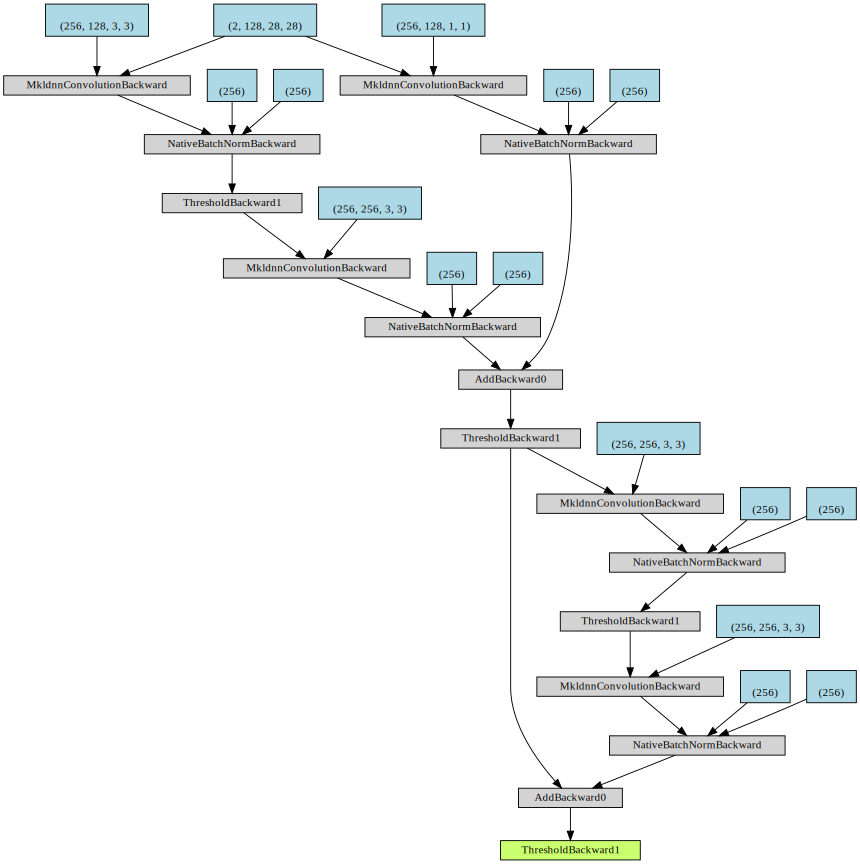

In [17]:
y2 = torch.rand(2, 128, 28, 28, requires_grad=True)
y3 = model.layer3(y2)
print(y2.shape, y3.shape)
make_dot(y3)

Layer 4

torch.Size([2, 256, 14, 14]) torch.Size([2, 512, 7, 7])


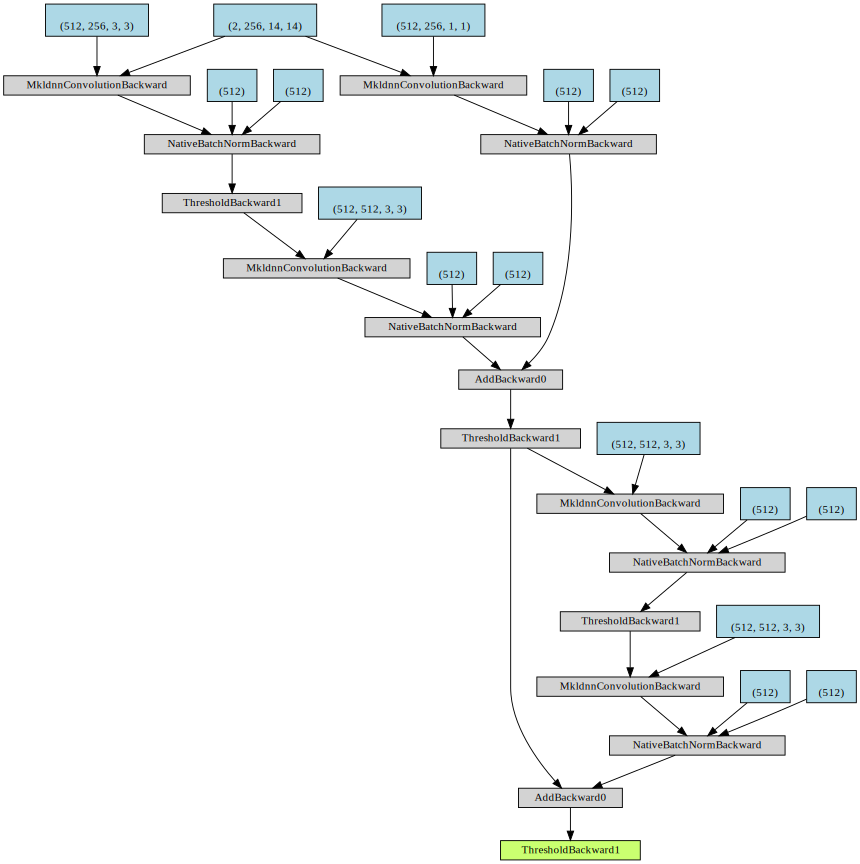

In [18]:
y3 = torch.rand(2, 256, 14, 14, requires_grad=True)
y4 = model.layer4(y3)
print(y3.shape, y4.shape)
make_dot(y4)

### Resnet34

Network contains (3, 4, 6, 3) basic blocks

```
model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
```

In [19]:
from torchvision.models.resnet import resnet34

In [20]:
model = resnet34(pretrained=False)

x = torch.rand(2, 3, 224, 224)

Preparation block

In [21]:
y = model.conv1(x)
y = model.bn1(y)
y = model.relu(y)
y = model.maxpool(y)
y.shape

torch.Size([2, 64, 56, 56])

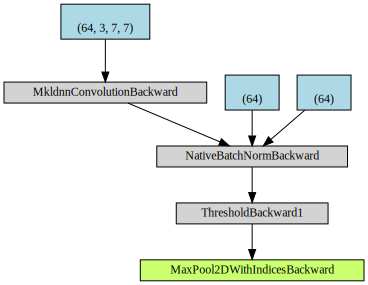

In [22]:
make_dot(y)

Layer 1

In [23]:
model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [24]:
y = torch.rand(2, 64, 112, 112, requires_grad=True)
y1 = model.layer1(y)
y1.shape

torch.Size([2, 64, 112, 112])

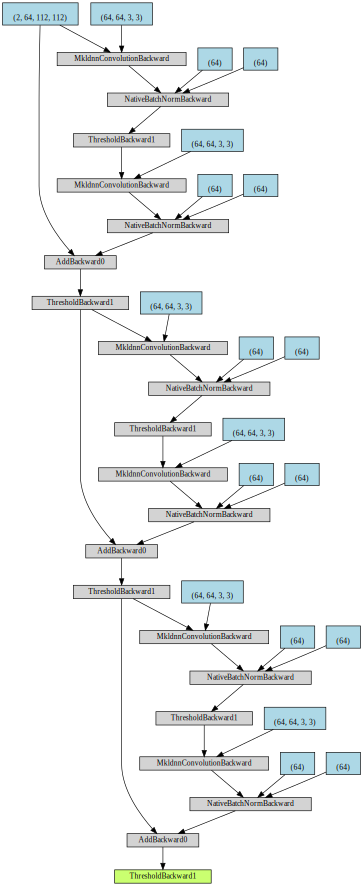

In [25]:
make_dot(y1)

Layer 2

In [26]:
model.layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

torch.Size([2, 64, 56, 56]) torch.Size([2, 128, 28, 28])


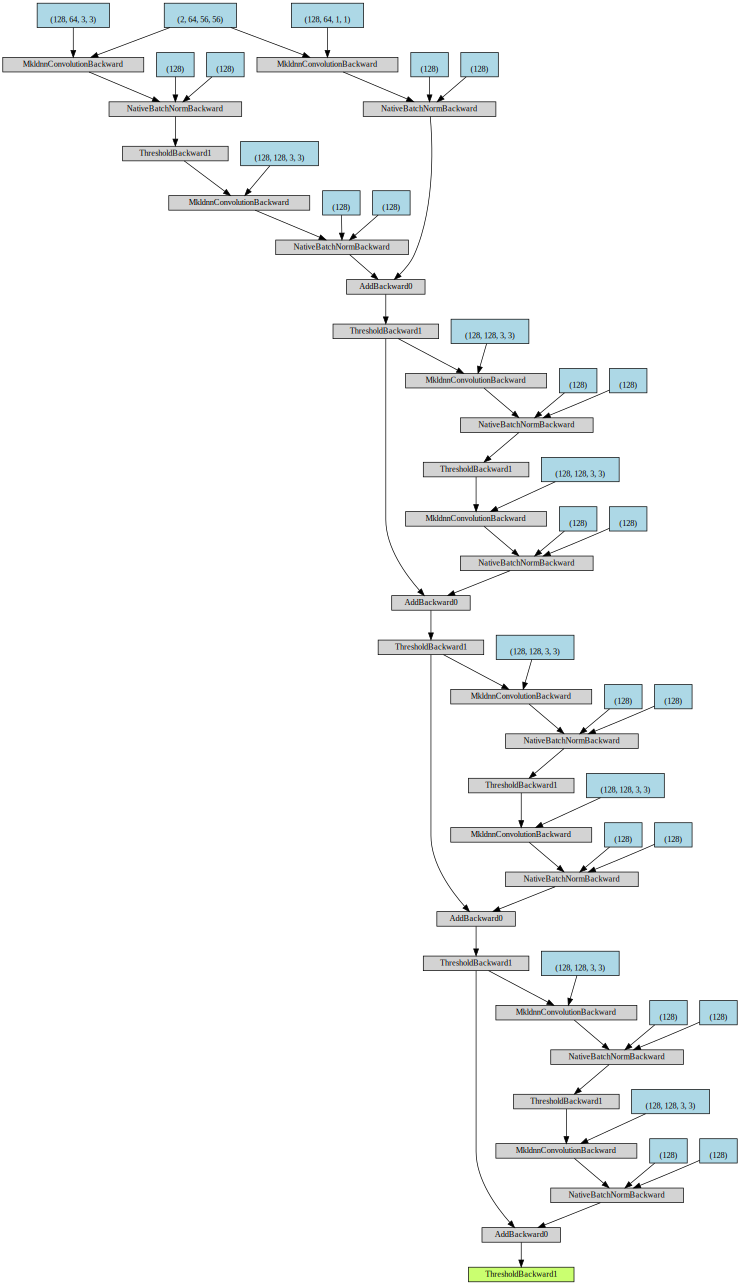

In [27]:
y1 = torch.rand(2, 64, 56, 56, requires_grad=True)
y2 = model.layer2(y1)
print(y1.shape, y2.shape)
make_dot(y2)

Layer 3

torch.Size([2, 128, 28, 28]) torch.Size([2, 256, 14, 14])


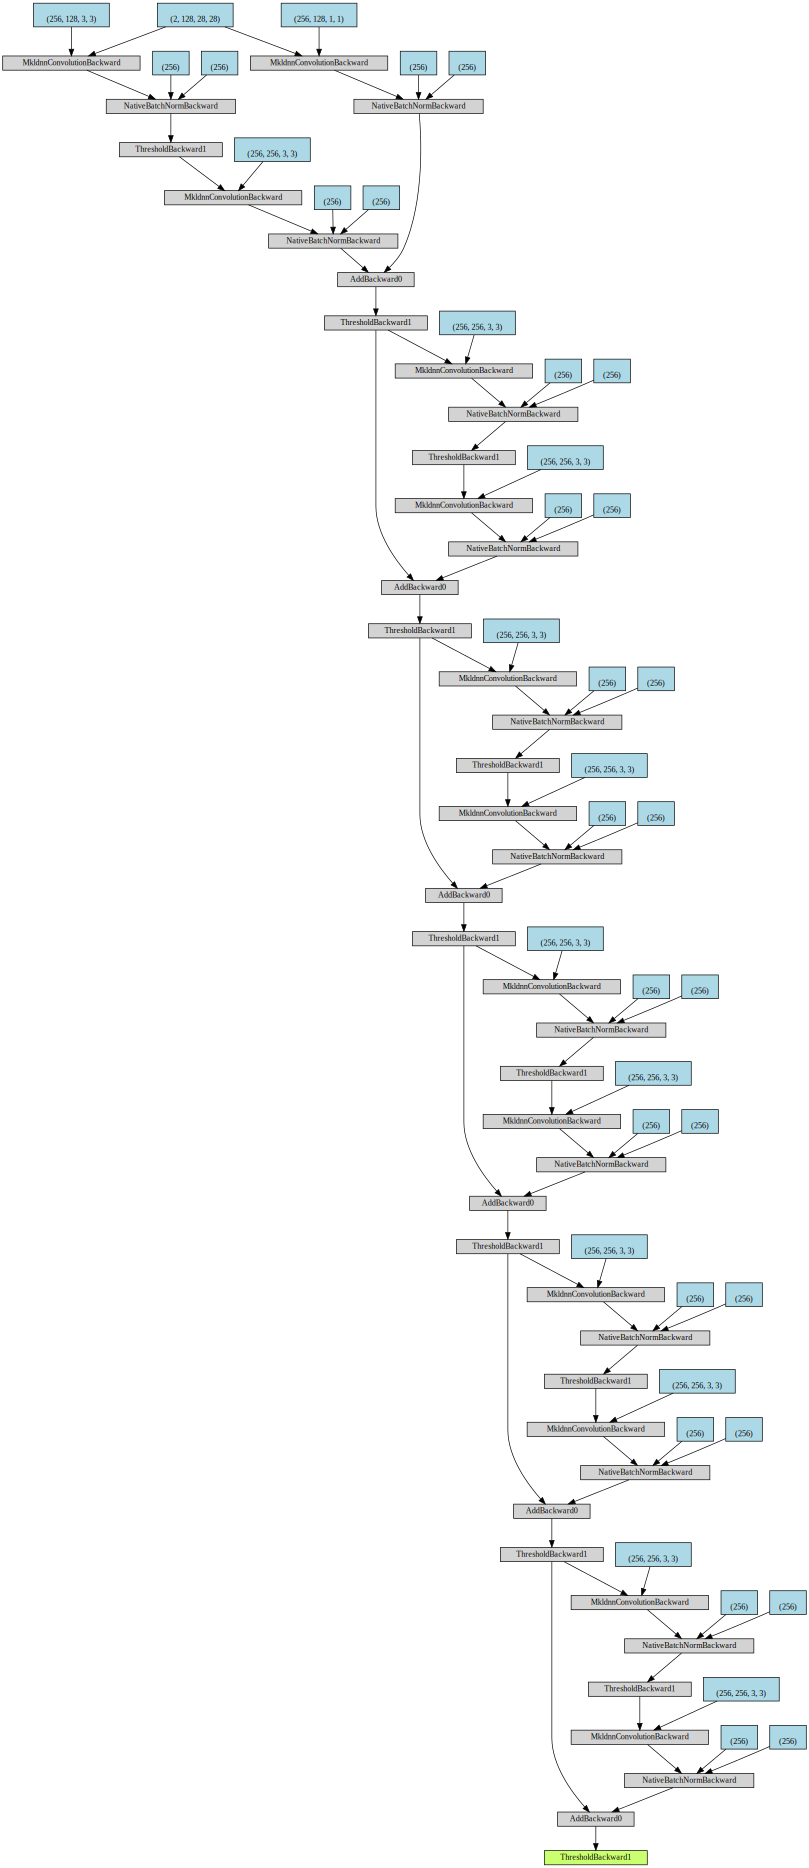

In [28]:
y2 = torch.rand(2, 128, 28, 28, requires_grad=True)
y3 = model.layer3(y2)
print(y2.shape, y3.shape)
make_dot(y3)

Layer 4

torch.Size([2, 256, 14, 14]) torch.Size([2, 512, 7, 7])


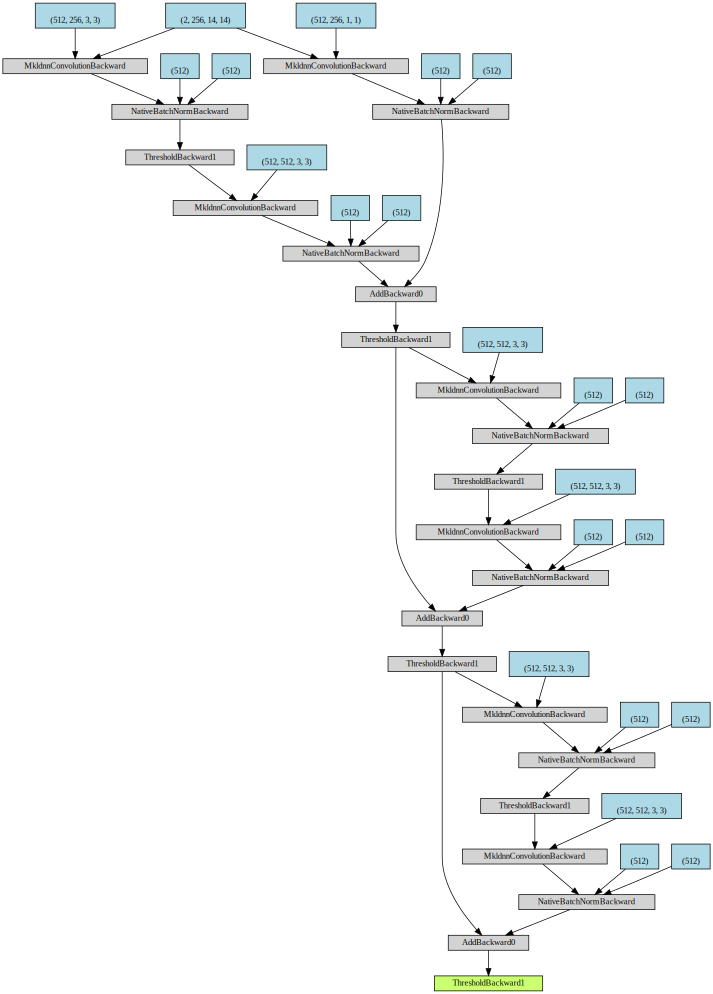

In [29]:
y3 = torch.rand(2, 256, 14, 14, requires_grad=True)
y4 = model.layer4(y3)
print(y3.shape, y4.shape)
make_dot(y4)

### Resnet50

Network contains (3, 4, 6, 3) basic blocks

```
model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
```

In [30]:
from torchvision.models.resnet import resnet50

In [31]:
model = resnet50(pretrained=False)

x = torch.rand(2, 3, 224, 224)

Preparation block

In [32]:
y = model.conv1(x)
y = model.bn1(y)
y = model.relu(y)
y = model.maxpool(y)
y.shape

torch.Size([2, 64, 56, 56])

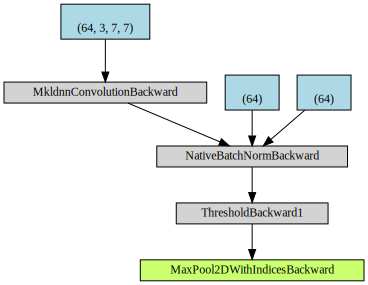

In [33]:
make_dot(y)

Layer 1

In [34]:
model.layer1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_

In [35]:
y = torch.rand(2, 64, 112, 112, requires_grad=True)
y1 = model.layer1(y)
y1.shape

torch.Size([2, 256, 112, 112])

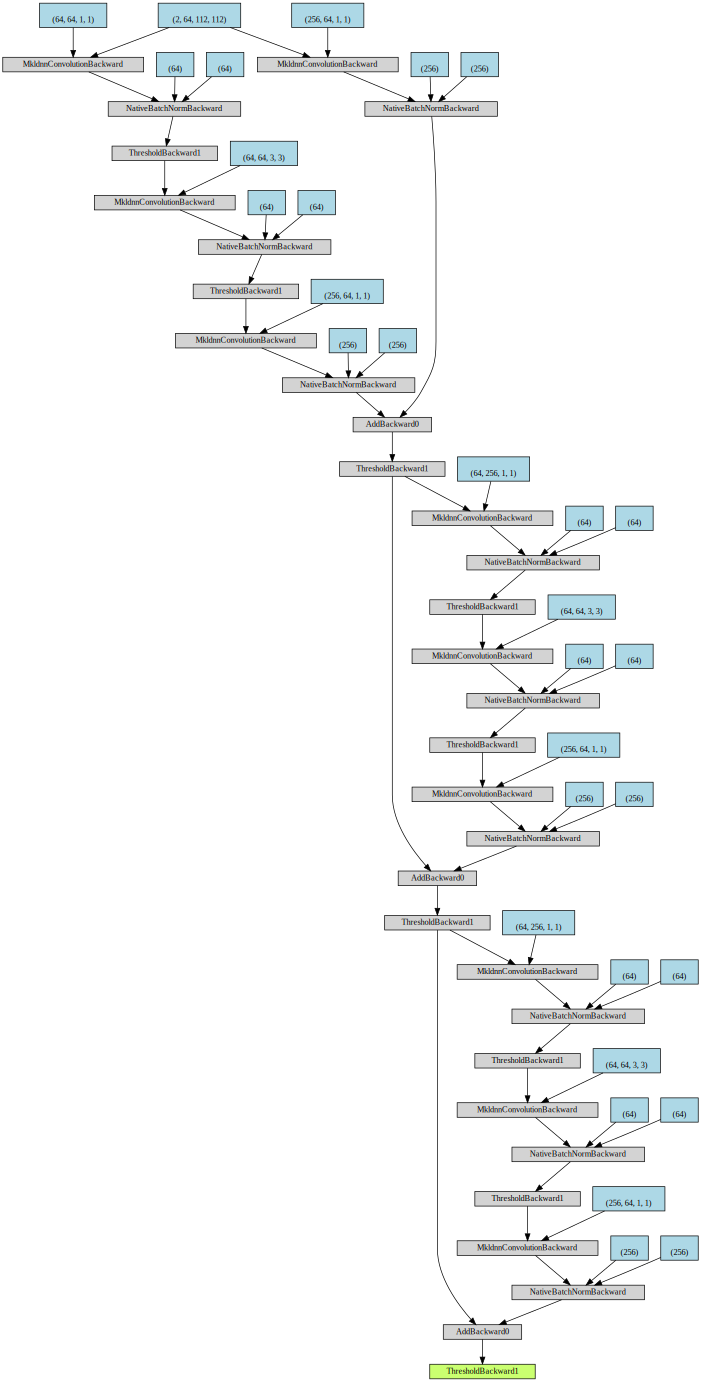

In [36]:
make_dot(y1)

Layer 2

In [37]:
model.layer2

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 

torch.Size([2, 256, 112, 112]) torch.Size([2, 512, 56, 56])


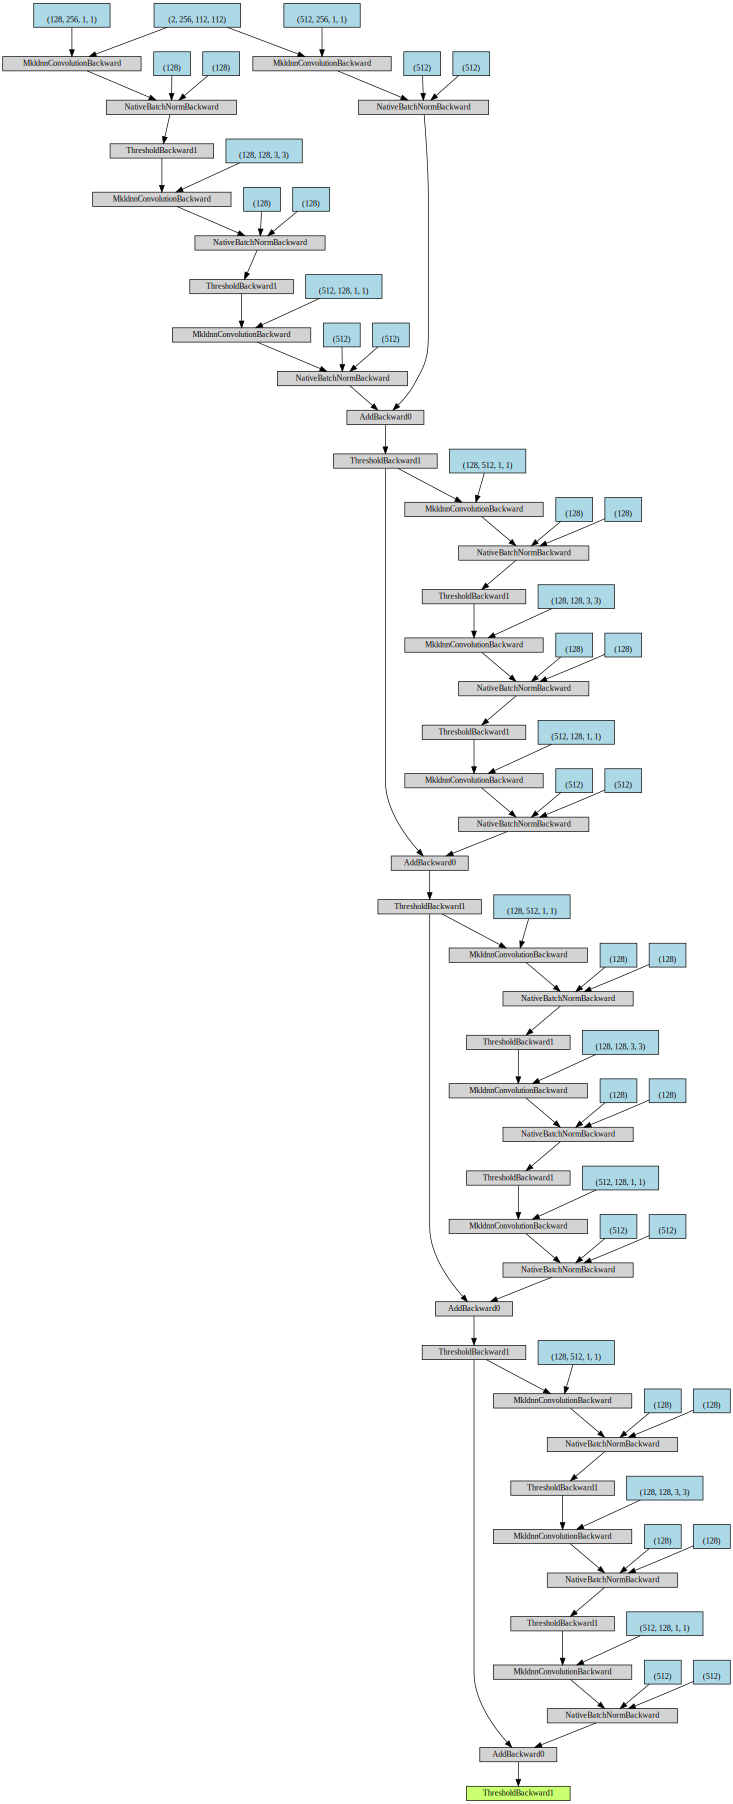

In [38]:
y1 = torch.rand(2, 256, 112, 112, requires_grad=True)
y2 = model.layer2(y1)
print(y1.shape, y2.shape)
make_dot(y2)

Layer 3

torch.Size([2, 512, 56, 56]) torch.Size([2, 1024, 28, 28])


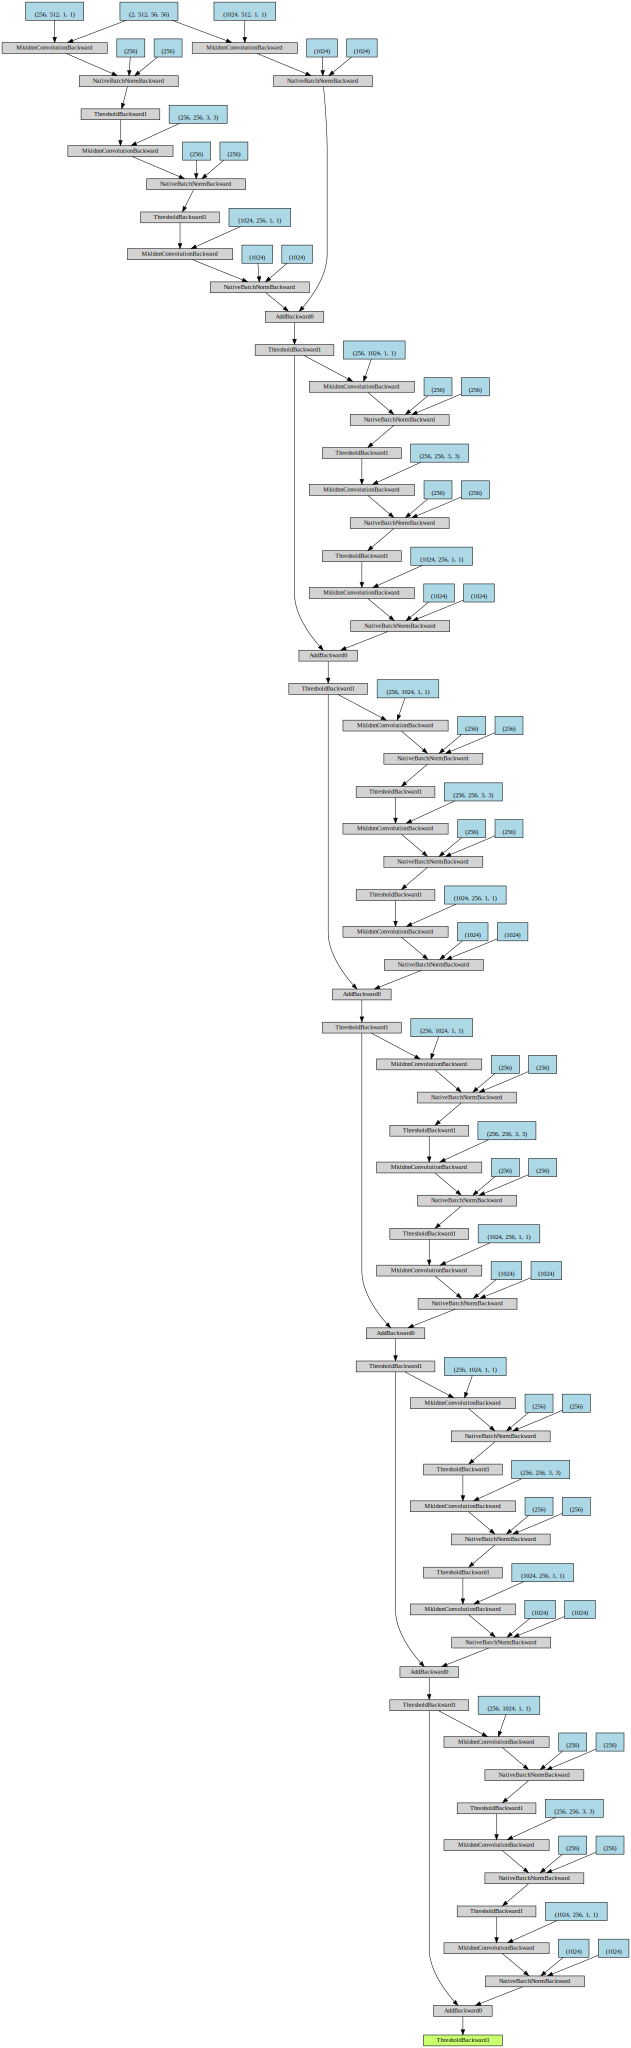

In [39]:
y2 = torch.rand(2, 512, 56, 56, requires_grad=True)
y3 = model.layer3(y2)
print(y2.shape, y3.shape)
make_dot(y3)

Layer 4

torch.Size([2, 1024, 28, 28]) torch.Size([2, 2048, 14, 14])


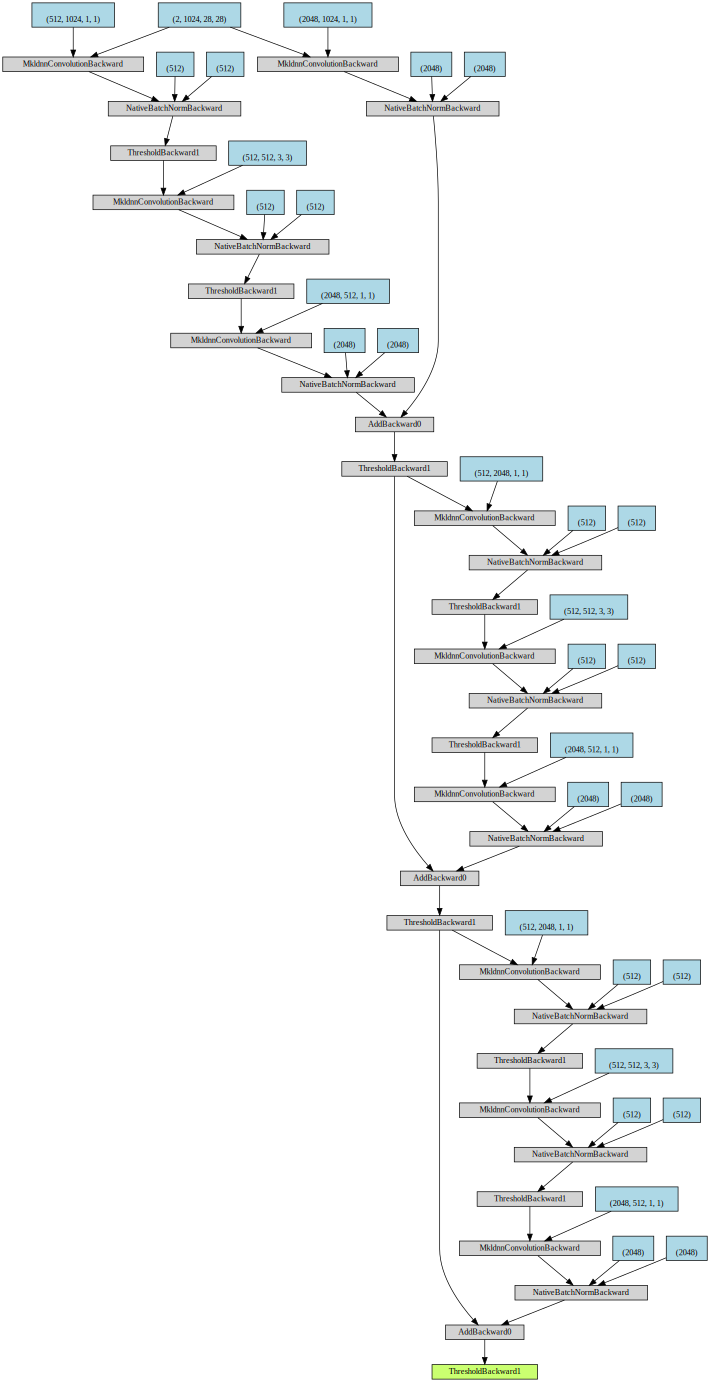

In [40]:
y3 = torch.rand(2, 1024, 28, 28, requires_grad=True)
y4 = model.layer4(y3)
print(y3.shape, y4.shape)
make_dot(y4)

### ResNet101 & ResNet152

ResNet101 contains (3, 4, 23, 3) basic blocks

```
model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
```

ResNet152 contains (3, 8, 36, 3) basic blocks

```
model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
```